# Quick Overview

This chapter gives a quick overview into how to use the package. Detailed explanations can be found in the subchapters of the respective sub-classes.

Import the package and give it an alias, e.g. `h5tbx`.

In [1]:
import h5rdmtoolbox as h5tbx
from h5rdmtoolbox import tutorial

## Select a convention
The file content is controlled by means of a `convention`. This means that specific attributes are required for HDF groups or datasets.

They can be understood as rules, which are validated during usage. To make those rules to become effective, the convention must be imported and enabled. Conventions can be created by the user, too. More on this [here](../conventions/standard_attributes.ipynb)

For now, we select the existing one, which is published on [Zenodo](https://zenodo.org/record/8276716)

In [2]:
cv = h5tbx.conventions.from_zenodo('8276817')
# cv = h5tbx.conventions.from_yaml(tutorial.get_standard_attribute_yaml_filename())
cv

Convention("planar-piv-convention")
contact: https://orcid.org/0000-0001-8729-0482
  File.__init__():
    * contact:
		Contact or responsible person represented by an ORCID-ID.
    * standard_name_table (default=<h5rdmtoolbox.conventions.consts.DefaultValue object at 0x0000021CA5744F10>):
		The standard name table of the convention.
    * comment (default=None):
		A comment to further describe the data.
    * references (default=None):
		Web resources servering as references for the data
  Group.create_dataset():
    * units:
		Physical unit of the dataset.
    * standard_name:
		Standard name of the dataset. If not set, the long_name attribute must be given.
    * long_name:
		An comprehensive description of the dataset. If not set, the standard_name attribute must be given.
    * scale (default=None):
		Scale factor for the dataset values.
    * offset (default=None):
		Scale factor for the dataset values.
    * comment (default=None):
		A comment to further describe the data.
    * 

From the above representation string of the convention object we can read which attributes are *optional* or **required** for file creation (`__init__`), dataset creation (`create_dataset`) or group creation (`create_group`).

Without enabling the convention, the working with HDF5 files through the `h5rdmtoolbox` is almost (we got a few additional features which make life a bit easier) as by using `h5py`:

In [3]:
with h5tbx.File() as h5:
    h5.dump()

##### Now, we enable the convention ...

In [4]:
h5tbx.use(cv)

... and get an error, because we are not providing a contact:

In [5]:
try:
    with h5tbx.File() as h5:
        pass
except Exception as e:
    print(e)

The standard attribute "contact" is required but not provided.


## Difference to `h5py` package

The `h5RDMtoolbox` is built upon the `h5py` package. Besides the ability to include conventions, more convenient features are implemented.

### Filename
We could already see, that we did not have to provide a filename when creating a new file. If none is provided, a temporary file is created. Also, `hdf_filename` is provided as an additional property allowing work with the filename even after the file has been closed *and* to work with `pathlib.Path` objects instead of strings:

In [6]:
with h5tbx.File(contact='https://orcid.org/0000-0001-8729-0482') as h5:
    pass
h5.hdf_filename.name  # equal to h5.filename but a pathlib.Path and exists also after the file is closed

'tmp2.hdf'

## Datasets/xarray interface

With the `h5rdmtoolbox` you receive a `xr.DataArray` object instead of a `np.ndarray` when an HDF5 dataset is sliced. Thus, meta information (the attributes of the dataset) is still provided with the data and useful features like plotting is possible.

Let's create some sample data and inspect the data afterwards:

In [7]:
import numpy as np

time = np.linspace(0, np.pi/4, 21) # units [s]
signal = np.sin(2*np.pi*3*time) # units [V], physical: [m/s]

with h5tbx.File(contact='https://orcid.org/0000-0001-8729-0482') as h5:
    vel_hdf_filename = h5.hdf_filename # store for later use
    
    ds_time = h5.create_dataset(name='time',
                                data=time, 
                                units='s',
                                long_name='measurement time',
                                make_scale=True)
    
    ds_signal = h5.create_dataset(name='vel',
                                  data=signal,
                                  units='V',
                                  offset=10.0,
                                  scale='2.5 m/s/V',
                                  long_name='air velocity in pipe',
                                  attach_scale=ds_time)

C:\Users\da4323\Documents\programming\GitHub\h5RDMtoolbox\h5rdmtoolbox\wrapper\core.py:1895: UserWarning: mode is read only. Provided standard attributes are ignored: dict_keys(['standard_name_table', 'comment', 'contact', 'references'])
  warnings.warn(f'mode is read only. Provided standard attributes are ignored: {skwargs.keys()}')


<xarray.DataArray 'vel' (time: 21)>
-25.0 -23.31 -22.51 -23.01 -24.55 -26.33 ... -26.65 -24.96 -23.28 -22.51 -23.04
Coordinates:
  * time     (time) float64 0.0 0.03927 0.07854 0.1178 ... 0.7069 0.7461 0.7854
Attributes:
    long_name:  air velocity in pipe
    units:      m/s

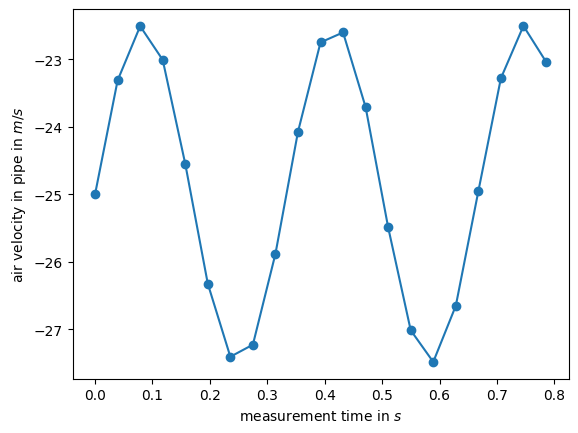

In [8]:
with h5tbx.File(vel_hdf_filename) as h5:
    vel_data = h5['vel'][:]
    vel_data.plot(marker='o')
    
vel_data  # this returns the interactive view of the array and its meta data

## Natural Naming
Until here we used the conventional way of addressing variables and groups in a dictionary-like style. `h5RDMtoolbox` allows to use "natural naming" which means that we can address those objects as if they were attributes. Make sure `h5tbx.config.natural_naming` is set to `True` (the default)

Let's first disable `natural_naming`:

In [9]:
with h5tbx.set_config(natural_naming=False):
    with h5tbx.File(vel_hdf_filename, 'r') as h5:
        try:
            ds = h5.vel[:]
        except Exception as e:
            print(e)

'File' object has no attribute 'vel'


Enable it:

In [10]:
with h5tbx.set_config(natural_naming=True):
    with h5tbx.File(vel_hdf_filename, 'r') as h5:
        ds = h5.vel[:]

## Inspect file content
Often it is necessary to inspect the content of a file (structure, meta data, not the raw data). Calling `dump()` on a group represents the content (dataset, groups and attributes) as a pretty nd interactive (!) html representation. This is adopted from the `xarray` package. All credits for this idea go there. The representation here avoids showing data, though. Outside an IPython environment call `sdump()` to get a string representation of the file.

In [11]:
with h5tbx.File(vel_hdf_filename) as h5:
    h5.dump()

In [12]:
with h5tbx.File(vel_hdf_filename) as h5:
    h5.sdump()

a: __h5rdmtoolbox_version__: 0.8.0a0
a: contact: ['https://orcid.org/0000-0001-8729-0482']
a: standard_name_table: 10.5281/zenodo.8266929
time: (21,), dtype: float64
    a: long_name: measurement time
    a: units: s
vel: (21,), dtype: float64
    a: long_name: air velocity in pipe
    a: offset: 10.0
    a: scale: 2.5 m/s/V
    a: units: V


### Layouts

Layouts define how a file is expected to be orginzed, which groups and datasets must exist, which attributes are expected and much more. Layout define expectations an thus help file exchange where multiple users are involved. E.g. for numerical and experimental data, layouts are defined such that the minimum data will exist. If a layout validation exist, the exchanged file is rejected.

In [13]:
from h5rdmtoolbox.conventions.layout import Validator
import datetime

class ValidCreationTime(Validator):
    
    def __init__(self, optional):
        super().__init__(reference=None, optional=optional)
    
    def validate(self, date_string):
        try:
            dt = datetime.datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S.%f')
        except Exception as e:
            print(e)
            return False
        return True

In [14]:
from h5rdmtoolbox.conventions.layout import Layout, validators

lay = h5tbx.conventions.layout.Layout()
lay['/'].attrs['creation_time'] = ValidCreationTime(False)
lay['/'].attrs['title'] = validators.ValidString(False)

In [15]:
with h5tbx.use(None): # switch off the convention for now
    with h5tbx.File() as h5:
        lay.validate(h5)
lay.report()

Layout Validation report
------------------------
Number of validations (called/specified): 3/3
Number of inactive validations: 0
Success rate: 33.3% (n_fails=2)


In [16]:
lay.get_failed_validations()

[ValidationResult("/" is missing required attributes: ["Equal('creation_time')=ValidCreationTime(None)"]),
 ValidationResult("/" is missing required attributes: ["Equal('title')=ValidString('^[^ 0-9].*')"])]

In [17]:
with h5tbx.use(None): # switch off the convention for now
    with h5tbx.File() as h5:    
        h5.attrs['creation_time'] = str(datetime.datetime.now())
        lay.validate(h5)
lay.report()

Layout Validation report
------------------------
Number of validations (called/specified): 3/3
Number of inactive validations: 0
Success rate: 66.7% (n_fails=1)


In [18]:
lay.get_failed_validations()

[ValidationResult("/" is missing required attributes: ["Equal('title')=ValidString('^[^ 0-9].*')"])]

In [19]:
with h5tbx.use(None): # switch off the convention for now
    with h5tbx.File() as h5:
        h5.attrs['creation_time'] = str(datetime.datetime.now())
        h5.attrs['title'] = 'Test file'
        lay.validate(h5)
lay.report()

Layout Validation report
------------------------
Number of validations (called/specified): 3/3
Number of inactive validations: 0
Success rate: 100.0% (n_fails=0)
